## Init fast ai

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.0 MB/s eta 0:00:00
Mounted at /content/gdrive


## 数据准备

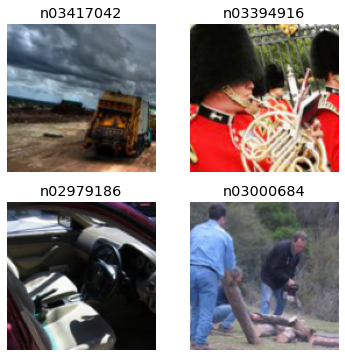

In [2]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

dls = get_data(URLs.IMAGENETTE_160, 160, 128)
dls.show_batch(max_n=4)

## Average Activation

在图片分类问题中, 我们通过stride-2的网络层来降维, 最终输出的tensor为1x1. 原来的设计有两个问题:

* 我们需要足够多stride-2的网络层, 来使我们最终tensor输出为1x1.

* 我们的模型只能处里一种固定分辨率的输入.

这个问题可以通过全卷积网络(fully convolutional networks)来解决: 通过取activation grid的平均值地方式进行维度转换. PyTorch中的函数: `nn.AdaptiveAvgPool2d` 可以帮我们通过取activation grid平均值得方式, 进行任意的维度转换.

In [ ]:
m = nn.AdaptiveAvgPool2d((5,7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
output.shape

torch.Size([1, 64, 5, 7])

In [ ]:
ConvLayer??

## 经典CNN模型

In [ ]:
def get_learner(m):
  # 这里nn.CrossEntropyLoss与F.cross_entropy基本是一样的, 前者需要新建类对象, 而后者是函数, 直接使用.
  return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

In [ ]:
def get_model():
  return nn.Sequential(
    ConvLayer(3, 16, stride=2), # sequence of convolutional, ks=3
    ConvLayer(16, 32, stride=2),
    ConvLayer(32, 64, stride=2),
    ConvLayer(64, 128, stride=2),
    ConvLayer(128, 256),
    nn.AdaptiveAvgPool2d(1), # output width = height = 1
    Flatten(), # 第0维保持不变, 后续维度展平到第1维
    nn.Linear(256, dls.c) # 线性层, y = x A^T + b; A^T 维度:(256, dls.c)
  )

In [ ]:
learner = get_learner(get_model())
learner.summary()

/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Sequential (Input shape: 128 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 16 x 64 x 64  
Conv2d                                    432        True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 32 x 32  
Conv2d                                    4608       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 16 x 16  
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
__________________________________

In [ ]:
#??Flatten

a = torch.randn(10, 3, 10, 10)
m = Flatten()
b = m(a)
b.shape

torch.Size([10, 300])

In [ ]:
??nn.Linear

/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(valley=0.0003311311302240938)

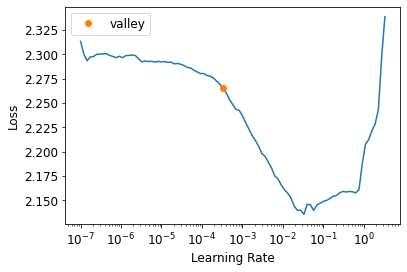

In [ ]:
lr = learner.lr_find()

In [ ]:
learner.fit_one_cycle(5, 3e-3)

/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,1.878762,1.932200,0.379363,02:47
1,1.536039,1.455289,0.529682,02:41
2,1.311491,1.291717,0.574268,02:32
3,1.146313,1.142166,0.633885,02:42
4,1.058993,1.087971,0.657070,03:02


## ResNet

2015年, ResNet的论文揭示了一个反直觉的现象, 我们用更深的网络结构训练得到的结果反而会变差. 而此结果并不是由于过拟合导致的, 在训练集和验证集上的均有此现象.

从直觉上来说, 在网络结构中多加入几层, 只要让这几层拟合为`identity mapping`, 结果应该和不加是一样的. 然而由于训练算法(SGD优化方法)在数学设计上, 无法找到这样的解, 导致最终结果反而变差.

为此, 作者提出将下一个layer的结果由`conv(x)` 改为`conv(x) + x`, 从而使得训练算法可以更方便地找到更好地局部最优解. 从直觉上说, `conv(x)`不容易找到`identity mapping`, 却很容易找到`zero mapping`. 本质上, RestNet使得loss function更加平滑, 2018年的论文 [Visualizing the Loss Landscape of Neural Nets](https://arxiv.org/abs/1712.09913) 展示了该结论:

![smooth_loss_function](https://docs.google.com/uc?id=1Soiguuy8momlzs5L4mZzsXfxBSW3LOvP)

![resnet_block](https://docs.google.com/uc?id=1ljPw-ZDv7j7cC-V8YzlC_LbGLC3Nr9Ug)

据此, 我们可以先训练一个浅层的模型, 然后再加入新的层, 新的层`x+conv(x)`, 初始化时另其在归一化时输出`identity mapping`, 再训练.

在ResNet的设计中, 我们采取更巧妙的方法, 转而训练函数`H(x) = F(x) + x`.


### 使用ResNetBlock重新定义模型

In [ ]:
def get_learner(m):
  # 这里nn.CrossEntropyLoss与F.cross_entropy基本是一样的, 前者需要新建类对象, 而后者是函数, 直接使用.
  return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

convs中拟合的是目标`H(x)=y-x`. 在初始化时, 最后一层BN的weight初始化为0, 即初始化时H(x)=0. 由于input x与目标输出y之间feature number, width, height可能不同, 因此不能简单地`y = H(x) + x`. 而是`y=H(x) + idconv(x)`.

In [ ]:
class ResNetBlock(Module):
  def __init__(self, ni, nf, stride=1):
    self.convs = nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero) # norm_type=NormType.BatchZero 
        )
    self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None) # noop(x) = x
    self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # kernel size=2, 

  
  def forward(self, x):
    return F.relu(self.convs(x)+self.idconv(self.pool(x)))

In [ ]:
def get_resnet_model():
  return nn.Sequential(
    ResNetBlock(3, 16, stride=2), # sequence of convolutional, ks=3
    ResNetBlock(16, 32, stride=2),
    ResNetBlock(32, 64, stride=2),
    ResNetBlock(64, 128, stride=2),
    ResNetBlock(128, 256),
    nn.AdaptiveAvgPool2d(1), # output width = height = 1
    Flatten(), # 第0维保持不变, 后续维度展平到第1维
    nn.Linear(256, dls.c) # 线性层, y = x A^T + b; A^T 维度:(256, dls.c)
  )

learner = get_learner(get_resnet_model())

参数数量的计算:
$$ param_{BN} = n_f * 2 $$
$$ param_{Conv2d}=k_{w} * k_{h} * n_i * n_f$$

In [ ]:
learner.summary()

Sequential (Input shape: 128 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 16 x 64 x 64  
Conv2d                                    432        True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
Conv2d                                    48         True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     128 x 3 x 64 x 64   
AvgPool2d                                                      
____________________________________________________________________________
                     128 x 32 x 32 x 32  
Conv2d                                    4608       True      
BatchNorm2d                       

进行训练:

In [ ]:
learner.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.972777,1.878080,0.336561,00:42
1,1.695701,1.548129,0.492994,00:31
2,1.412538,1.316608,0.578599,00:31
3,1.172572,1.089964,0.662166,00:32
4,1.058764,1.078946,0.663185,00:34


使用ResNet之后, 可以对网络进行加深

In [ ]:
def get_resnet_model():
  return nn.Sequential(
    ResNetBlock(3, 16, stride=2),
    ResNetBlock(16, 16, stride=1), # add
    ResNetBlock(16, 32, stride=2),
    ResNetBlock(32, 32, stride=1), # add
    ResNetBlock(32, 64, stride=2),
    ResNetBlock(64, 64, stride=1), # add
    ResNetBlock(64, 128, stride=2),
    ResNetBlock(128, 128, stride=1), # add
    ResNetBlock(128, 256),
    ResNetBlock(256, 256, stride=1), # add
    nn.AdaptiveAvgPool2d(1), # output width = height = 1
    Flatten(), # 第0维保持不变, 后续维度展平到第1维
    nn.Linear(256, dls.c) # 线性层, y = x A^T + b; A^T 维度:(256, dls.c)
)

learner = get_learner(get_resnet_model())

In [ ]:
learner.summary()

Sequential (Input shape: 128 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 16 x 64 x 64  
Conv2d                                    432        True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
Conv2d                                    48         True      
BatchNorm2d                               32         True      
____________________________________________________________________________
                     128 x 3 x 64 x 64   
AvgPool2d                                                      
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                   

这里准确率略有提高

In [ ]:
learner.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.971899,1.849174,0.368662,00:33
1,1.626543,1.563814,0.470573,00:32
2,1.337521,1.276378,0.590319,00:32
3,1.107593,1.022672,0.678981,00:32
4,0.958434,0.961256,0.693503,00:32


## 进一步优化

### 初始几层使用普通卷积

我们在模型开始的几层中使用普通卷积层, 原因是:大部分计算集中在前几层, 而大部分参数主要在后几层. 在开始这几层使用普通卷积, 可以大大减少数据量.

由于前几层grid的size比较大, 计算量大. 然而, 由于前几层feature比较少, 于是kernel的参数就比较少.

In [3]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [4]:
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

ResNet模型的定义:

In [5]:
class ResNetBlock(Module):
  def __init__(self, ni, nf, stride=1):
    self.convs = nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero) # norm_type=NormType.BatchZero 
        )
    self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None) # noop(x) = x
    self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # kernel size=2, 

  
  def forward(self, x):
    return F.relu(self.convs(x)+self.idconv(self.pool(x)))


class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2 # 这个地方why?
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResNetBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers) # 第一层ch_in,chout,stride=2, 第二层ch_out, ch_out stride=1
        ])

In [6]:
def get_learner(m):
  # 这里nn.CrossEntropyLoss与F.cross_entropy基本是一样的, 前者需要新建类对象, 而后者是函数, 直接使用.
  return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

In [7]:
rn = ResNet(dls.c, [2,2,2,2])
learner = get_learner(rn)

In [ ]:
learner.summary()

In [8]:
learner.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.678221,2.301110,0.371210,00:39
1,1.329851,1.891789,0.471592,00:34
2,1.083029,0.980450,0.681529,00:32
3,0.889290,0.902170,0.711847,00:36
4,0.755271,0.765311,0.755669,00:33


### 使用Bottleneck Layers

在之前的设计中, 我们使用了两个3x3的卷积, 改用前后两个1x1卷积+中间3x3卷积, 可以进一步减少计算量. 对比下图两个设计, 虽然右侧增加了feature数量, 但计算量却减少了. 我们可以添加更多的网络层.

![bottleneck_layers](https://docs.google.com/uc?id=1Nnle9RHatZE-X_LwIn-xD60Ixki-IKy2)



这个地方, 将group size, feature_expantion = 4, 过程中会//4, 简单理解为为了保持网络的能力.

In [18]:
class ResNetBlock(Module):
  def __init__(self, ni, nf, stride=1):
    #self.convs = nn.Sequential(
    #    ConvLayer(ni, nf, stride=stride),
    #    ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero) # norm_type=NormType.BatchZero 
    #    )
    self.convs = nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride),
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero)

    )
    self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None) # noop(x) = x
    self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True) # kernel size=2, 

  
  def forward(self, x):
    return F.relu(self.convs(x)+self.idconv(self.pool(x)))

In [ ]:
#rn = ResNet(dls.c, [3,4,6,3], 4)
#learner = get_learner(rn)
#learner.summary()

In [ ]:
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

In [ ]:
rn = ResNet(dls.c, [3,4,6,3], 4)
#learner.summary()

In [22]:
learner = get_learner(rn)
learner.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.605717,1.421283,0.541401,01:18
1,1.350718,1.964873,0.434140,01:13
2,1.269685,1.271680,0.584459,01:17
3,1.148031,1.696589,0.531210,01:16
4,1.062743,1.413210,0.541147,01:13
5,0.969531,1.353137,0.572484,01:17
6,0.868300,1.258116,0.621147,01:13
7,0.782723,0.996359,0.706242,01:16


KeyboardInterrupt: ignored

可以看到对于不同分辨率的input图片, 这两个模型是完全一样的(归功于最后一层AdaptiveAvgPool2d):

In [ ]:
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)
rn = ResNet(dls.c, [3,4,6,3], 4)
rn

In [ ]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)
rn = ResNet(dls.c, [3,4,6,3], 4)
rn